# Assignment 2 | Classification using Convolutional Neural Networks

Student 1 + ID: Bashar Beshoti, 207370248

Student 2 + ID: Selan Abu Saleh, 212111439

### Introduction: 

CNNs have revolutionized the field of computer vision, their unique 
architecture, inspired by the visual cortex, allows CNNs to learn 
intricate patterns in images—detecting edges, textures, and even 
complex features at multiple levels.

 In this assignment we will explore the power of different CNN 
architectures and how to apply them for learning state of the art image 
classification algorithms.

 This assignment is divided into two parts. In the first part, you will 
implement a simple CNN in different ways and compare the 
performance on image classification.
 In the second part, we will use a more powerful network to achieve an 
almost perfect score on a real life dataset.

## Pre-Tasks : Import Libraries

In [31]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PyTorch check:

In [32]:
# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# Check the device
device = torch.device("cuda" if cuda_available else "cpu")
print("Device:", device)

# If CUDA is available, print additional information
if cuda_available:
    print("CUDA version:", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device capability:", torch.cuda.get_device_capability(0))

# Check if cuDNN is available
cudnn_available = torch.backends.cudnn.is_available()
print("cuDNN available:", cudnn_available)

# Check the version of cuDNN
if cudnn_available:
    print("cuDNN version:", torch.backends.cudnn.version())

# Check if MPS (Metal Performance Shaders) is available (for macOS)
mps_available = torch.backends.mps.is_available()
print("MPS available:", mps_available)

# Check if MPS is built (for macOS)
mps_built = torch.backends.mps.is_built()
print("MPS built:", mps_built)

PyTorch version: 2.5.1+cpu
CUDA available: False
Device: cpu
cuDNN available: False
MPS available: False
MPS built: False


## Section 1:  (CNNs on CIFAR-10)
__Introduction:__  Part 1: (CNNs on CIFAR-10) In this part of the assignment, you will design, implement, and experiment with Convolutional Neural Networks (CNNs) on the CIFAR-10 dataset.

The goal is to understand how different configurations (number of layers, kernel sizes, strides, and pooling techniques) impact model performance on image classification tasks.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 
classes, with 6,000 images per class. There are 50,000 training images 
and 10,000 test images.


### A: Load the dataset using torchvision-datasets library. Split the dataset into training, validation and test sets if not already provided like that, and showcase some samples from different classes from the training set.

Files already downloaded and verified
Files already downloaded and verified
Showing some samples from the CIFAR-10 training set:


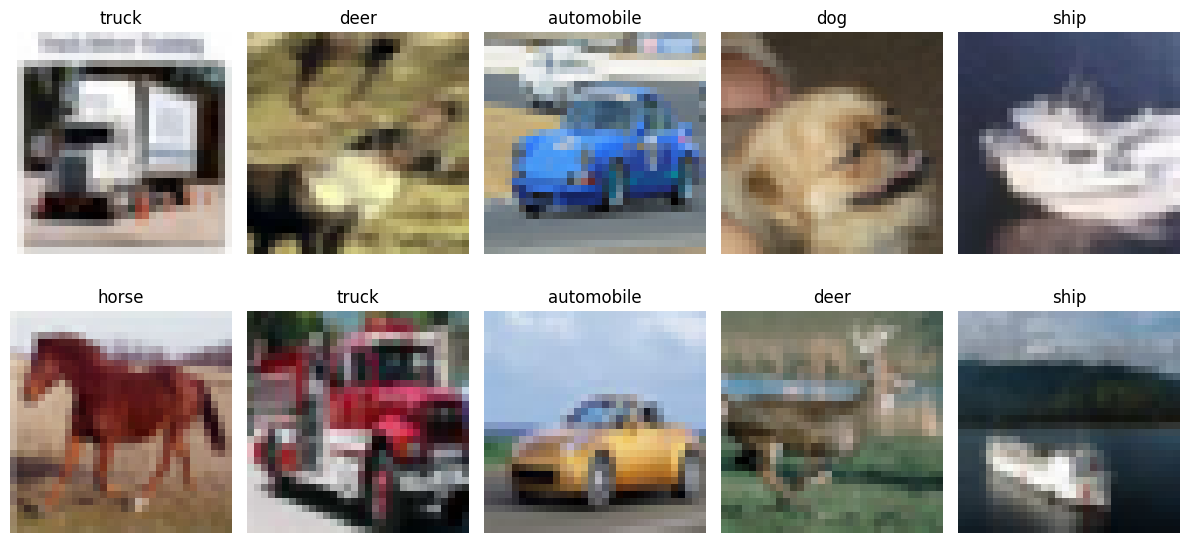

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [33]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchsummary import summary

# Define transformations (normalizing the data)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class labels in CIFAR-10
classes = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# Function to visualize some images
def show_samples(dataset, classes, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        # Get a random sample
        index = np.random.randint(0, len(dataset))
        img, label = dataset[index]
        img = img.permute(1, 2, 0)  # Change dimensions for visualization
        img = img * 0.5 + 0.5  # De-normalize the image

        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Showcase samples from the training set
print("Showing some samples from the CIFAR-10 training set:")
show_samples(train_dataset, classes)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

### B: The parameter search should be done on the validation set and then used to test the best model found on the test set.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm

In [52]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, num_layers=2, kernel_size=3, stride=1, pool_type='max'):
        super(SimpleCNN, self).__init__()
        in_channels = 3  # RGB channels
        layers = []

        for i in range(num_layers):
            out_channels = 32 * (i + 1)
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2),
                nn.ReLU(),
                nn.MaxPool2d(2) if pool_type == 'max' else nn.AvgPool2d(2)
            ])
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(in_channels * 8 * 8, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


In [36]:
# Train, validate, and test the model, storing metrics for visualization
def train_and_validate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=5):
    model = model.to(device)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)  # Use device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Use device
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        # Test phase
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Use device
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_acc = correct_test / total_test
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc:.3f}, "
              f"Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}")
    
    return train_losses, train_accuracies, val_accuracies, test_accuracies


In [37]:
# Function to plot the metrics
def plot_metrics(train_losses, train_accuracies, val_accuracies, test_accuracies, title=''):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss' + title, color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy' + title, color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy'+ title, color='orange')
    plt.plot(epochs, test_accuracies, label='Test Accuracy' + title, color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train, Validation, and Test Accuracy' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [74]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
train_losses, train_accuracies, val_accuracies, test_accuracies = train_and_validate(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)



100%|██████████| 625/625 [00:12<00:00, 49.47it/s]


Epoch 1/10: Train Loss: 1.411, Train Acc: 0.502, Val Acc: 0.601, Test Acc: 0.596


100%|██████████| 625/625 [00:13<00:00, 46.93it/s]


Epoch 2/10: Train Loss: 1.045, Train Acc: 0.637, Val Acc: 0.663, Test Acc: 0.659


100%|██████████| 625/625 [00:12<00:00, 49.45it/s]


Epoch 3/10: Train Loss: 0.911, Train Acc: 0.685, Val Acc: 0.682, Test Acc: 0.680


100%|██████████| 625/625 [00:12<00:00, 49.21it/s]


Epoch 4/10: Train Loss: 0.827, Train Acc: 0.715, Val Acc: 0.676, Test Acc: 0.672


100%|██████████| 625/625 [00:12<00:00, 49.16it/s]


Epoch 5/10: Train Loss: 0.766, Train Acc: 0.735, Val Acc: 0.680, Test Acc: 0.672


100%|██████████| 625/625 [00:12<00:00, 49.48it/s]


Epoch 6/10: Train Loss: 0.713, Train Acc: 0.755, Val Acc: 0.707, Test Acc: 0.704


100%|██████████| 625/625 [00:12<00:00, 49.53it/s]


Epoch 7/10: Train Loss: 0.667, Train Acc: 0.769, Val Acc: 0.703, Test Acc: 0.700


100%|██████████| 625/625 [00:12<00:00, 49.04it/s]


Epoch 8/10: Train Loss: 0.625, Train Acc: 0.784, Val Acc: 0.708, Test Acc: 0.703


100%|██████████| 625/625 [00:12<00:00, 49.68it/s]


Epoch 9/10: Train Loss: 0.588, Train Acc: 0.795, Val Acc: 0.698, Test Acc: 0.694


100%|██████████| 625/625 [00:12<00:00, 49.56it/s]


Epoch 10/10: Train Loss: 0.557, Train Acc: 0.808, Val Acc: 0.708, Test Acc: 0.702


#### After the training, choose a random image from the test set, push it 
through the model and print the convolution filters of the first layer after 
the training to see the feature maps and visualize what the model 
learned on it.

Visualizing the first convolutional layer filters:


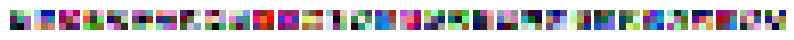

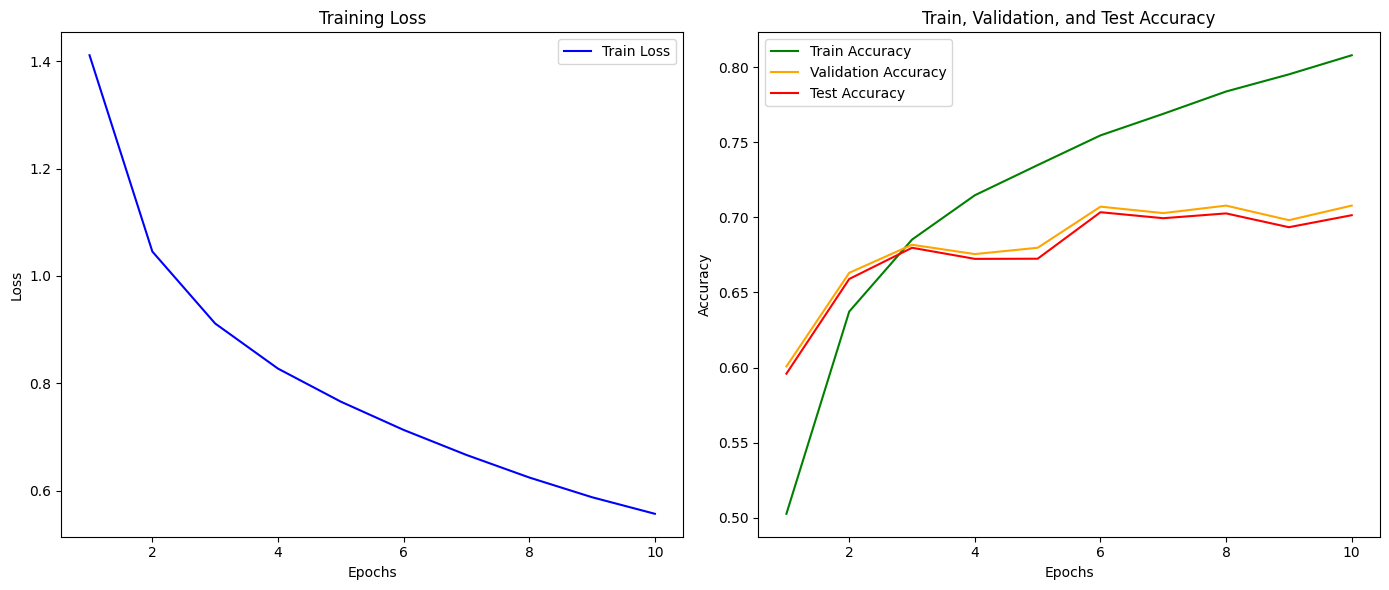

In [75]:
import random

# Choose a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Push the image through the model
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
model.eval()
with torch.no_grad():
    output = model(image)

# Get the first convolutional layer filters
first_conv_layer = model.conv[0]
filters = first_conv_layer.weight.data
num_filters = filters.size(0)

# Visualize the filters
def visualize_filters(filters, num_filters=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())  # Normalize to [0, 1]
        plt.imshow(filter_img)
        plt.axis('off')
    plt.show()

print("Visualizing the first convolutional layer filters:")
visualize_filters(filters,num_filters)

# Plot training and validation metrics
plot_metrics(train_losses, train_accuracies, val_accuracies, test_accuracies)

### C: You are given 4 subtasks where you will implement or add stuff on previous tasks, then compare the results and explain them.

    Subtask 1:
    Create a simple CNN with 2 convolutional layers and 1 fully connected layer with a softmax output such that:
    - Conv Layer 1 contains 16 filters of 3x3 kernels, stride 1, padding 1.
    - Conv Layer 2 contains 32 filters of 3x3 kernels, stride 1, padding 1.
    - Max Pooling  after each Conv layer
    - Flattening followed by a fully connected layer
    - Use Relu as an activation function on the convolutional layers, Adam or 
    - SGD as an optimizer and Cross Entropy as a loss function.
    Train the network on 10 epochs and test it.

100%|██████████| 625/625 [00:20<00:00, 29.84it/s]


Epoch 1/10: Train Loss: 1.501, Train Acc: 0.470, Val Acc: 0.553, Test Acc: 0.552


100%|██████████| 625/625 [00:20<00:00, 29.99it/s]


Epoch 2/10: Train Loss: 1.183, Train Acc: 0.588, Val Acc: 0.608, Test Acc: 0.600


100%|██████████| 625/625 [00:16<00:00, 37.10it/s]


Epoch 3/10: Train Loss: 1.047, Train Acc: 0.638, Val Acc: 0.644, Test Acc: 0.640


100%|██████████| 625/625 [00:09<00:00, 67.97it/s]


Epoch 4/10: Train Loss: 0.961, Train Acc: 0.666, Val Acc: 0.665, Test Acc: 0.660


100%|██████████| 625/625 [00:09<00:00, 67.30it/s]


Epoch 5/10: Train Loss: 0.903, Train Acc: 0.687, Val Acc: 0.677, Test Acc: 0.670


100%|██████████| 625/625 [00:09<00:00, 69.05it/s]


Epoch 6/10: Train Loss: 0.855, Train Acc: 0.702, Val Acc: 0.671, Test Acc: 0.668


100%|██████████| 625/625 [00:09<00:00, 69.31it/s]


Epoch 7/10: Train Loss: 0.818, Train Acc: 0.718, Val Acc: 0.682, Test Acc: 0.677


100%|██████████| 625/625 [00:09<00:00, 69.09it/s]


Epoch 8/10: Train Loss: 0.788, Train Acc: 0.727, Val Acc: 0.685, Test Acc: 0.680


100%|██████████| 625/625 [00:08<00:00, 70.22it/s]


Epoch 9/10: Train Loss: 0.765, Train Acc: 0.736, Val Acc: 0.679, Test Acc: 0.677


100%|██████████| 625/625 [00:08<00:00, 70.48it/s]


Epoch 10/10: Train Loss: 0.742, Train Acc: 0.742, Val Acc: 0.681, Test Acc: 0.682


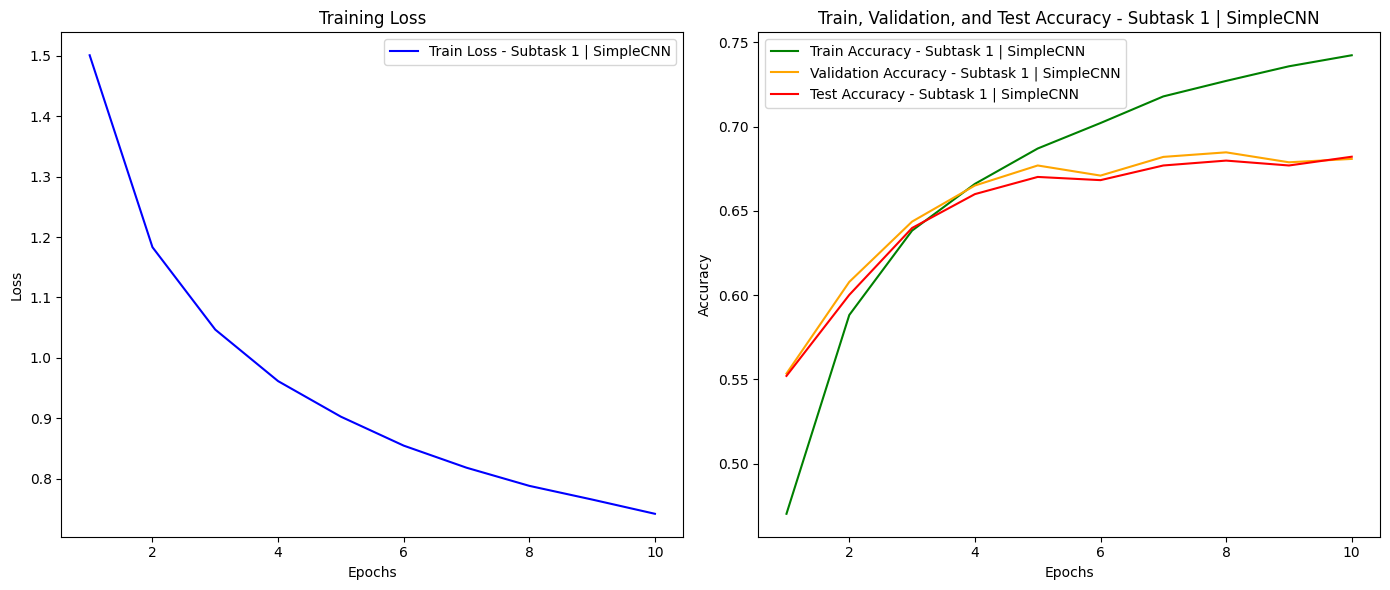

In [39]:
class SimpleCNN_subtask_1(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 8 * 8, 10)  # Assuming input images are 32x32 and output classes are 10
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
        # return self.softmax(x)

# Model, loss function, and optimizer
model_subtask_1 = SimpleCNN_subtask_1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask_1.parameters(), lr=0.001)

# Train the model and test it
train_losses_subtask1, train_accuracies_subtask1, val_accuracies_subtask1, test_accuracies_subtask1 = train_and_validate(
    model_subtask_1, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask1, train_accuracies_subtask1, val_accuracies_subtask1, test_accuracies_subtask1," - Subtask 1 | SimpleCNN")

    Subtask 2:
 
    - Increase the depth of the network by adding 2 additional layers.
    - The first additional one with 64 filters and the second additional one with 128 with the same kernel sizes as before.
    - Train and test the network and compare it with the previous ones.

100%|██████████| 625/625 [00:12<00:00, 48.85it/s]


Epoch 1/10: Train Loss: 1.599, Train Acc: 0.419, Val Acc: 0.521, Test Acc: 0.527


100%|██████████| 625/625 [00:12<00:00, 48.14it/s]


Epoch 2/10: Train Loss: 1.223, Train Acc: 0.563, Val Acc: 0.600, Test Acc: 0.605


100%|██████████| 625/625 [00:12<00:00, 48.39it/s]


Epoch 3/10: Train Loss: 1.047, Train Acc: 0.631, Val Acc: 0.640, Test Acc: 0.635


100%|██████████| 625/625 [00:13<00:00, 48.07it/s]


Epoch 4/10: Train Loss: 0.915, Train Acc: 0.679, Val Acc: 0.660, Test Acc: 0.655


100%|██████████| 625/625 [00:12<00:00, 48.39it/s]


Epoch 5/10: Train Loss: 0.815, Train Acc: 0.715, Val Acc: 0.683, Test Acc: 0.678


100%|██████████| 625/625 [00:13<00:00, 48.07it/s]


Epoch 6/10: Train Loss: 0.732, Train Acc: 0.744, Val Acc: 0.682, Test Acc: 0.683


100%|██████████| 625/625 [00:13<00:00, 47.70it/s]


Epoch 7/10: Train Loss: 0.667, Train Acc: 0.766, Val Acc: 0.706, Test Acc: 0.696


100%|██████████| 625/625 [00:13<00:00, 47.85it/s]


Epoch 8/10: Train Loss: 0.601, Train Acc: 0.790, Val Acc: 0.712, Test Acc: 0.709


100%|██████████| 625/625 [00:13<00:00, 47.65it/s]


Epoch 9/10: Train Loss: 0.541, Train Acc: 0.808, Val Acc: 0.705, Test Acc: 0.697


100%|██████████| 625/625 [00:13<00:00, 48.04it/s]


Epoch 10/10: Train Loss: 0.485, Train Acc: 0.829, Val Acc: 0.707, Test Acc: 0.699


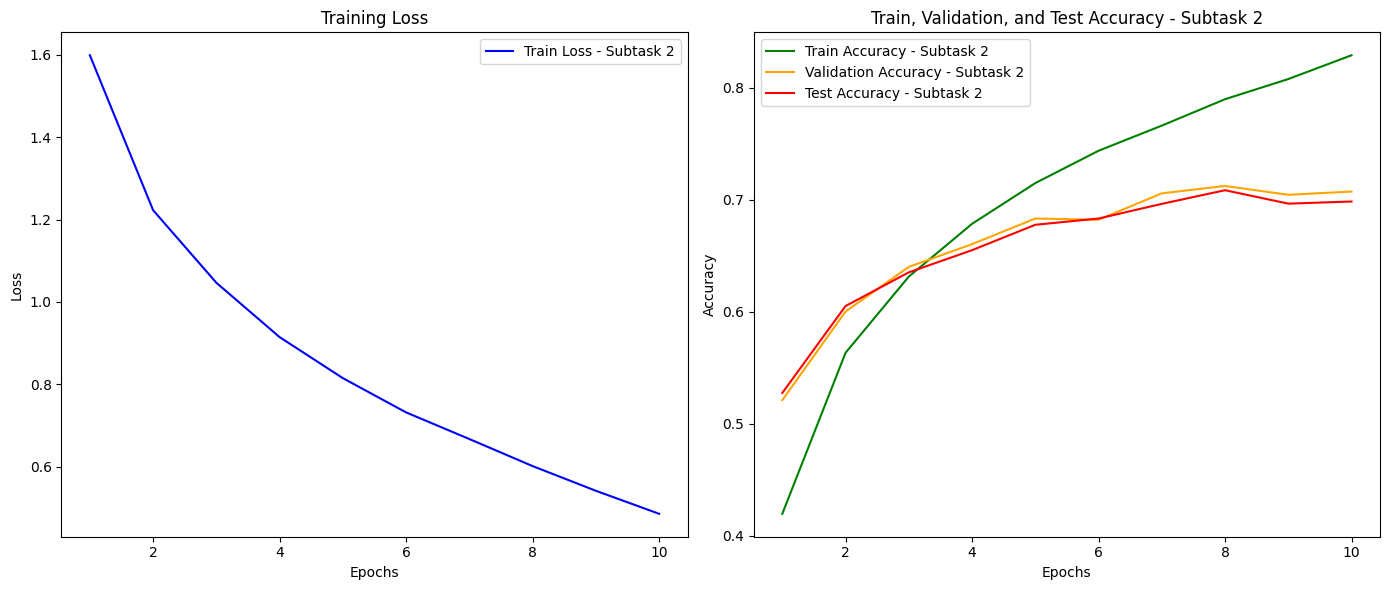

In [40]:
class SimpleCNN_subtask_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # New Layer 1
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # New Layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 2 * 2, 10)  # Updated to match the new feature map size
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))  # New Layer 1
        x = self.pool(x)
        x = self.relu(self.conv4(x))  # New Layer 2
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the new model
model_subtask_2 = SimpleCNN_subtask_2().to(device)

# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask_2.parameters(), lr=0.001)

# Train the model and test it
train_losses_subtask2, train_accuracies_subtask2, val_accuracies_subtask2, test_accuracies_subtask2 = train_and_validate(
    model_subtask_2, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask2, train_accuracies_subtask2, val_accuracies_subtask2, test_accuracies_subtask2," - Subtask 2")


    Subtask 3:

    - Remove the 2 new layers.
    - Increase the kernel sizes to 5x5 and the stride to 2.
    - Train and test the network and compare it with the previous.

100%|██████████| 625/625 [00:07<00:00, 81.41it/s]


Epoch 1/10: Train Loss: 1.609, Train Acc: 0.426, Val Acc: 0.508, Test Acc: 0.500


100%|██████████| 625/625 [00:07<00:00, 80.17it/s]


Epoch 2/10: Train Loss: 1.306, Train Acc: 0.539, Val Acc: 0.558, Test Acc: 0.552


100%|██████████| 625/625 [00:07<00:00, 80.03it/s]


Epoch 3/10: Train Loss: 1.196, Train Acc: 0.578, Val Acc: 0.588, Test Acc: 0.582


100%|██████████| 625/625 [00:07<00:00, 80.54it/s]


Epoch 4/10: Train Loss: 1.127, Train Acc: 0.605, Val Acc: 0.599, Test Acc: 0.595


100%|██████████| 625/625 [00:07<00:00, 81.87it/s]


Epoch 5/10: Train Loss: 1.077, Train Acc: 0.623, Val Acc: 0.606, Test Acc: 0.600


100%|██████████| 625/625 [00:07<00:00, 80.97it/s]


Epoch 6/10: Train Loss: 1.039, Train Acc: 0.636, Val Acc: 0.612, Test Acc: 0.614


100%|██████████| 625/625 [00:07<00:00, 81.86it/s]


Epoch 7/10: Train Loss: 1.008, Train Acc: 0.646, Val Acc: 0.616, Test Acc: 0.616


100%|██████████| 625/625 [00:07<00:00, 81.27it/s]


Epoch 8/10: Train Loss: 0.978, Train Acc: 0.658, Val Acc: 0.623, Test Acc: 0.617


100%|██████████| 625/625 [00:07<00:00, 81.02it/s]


Epoch 9/10: Train Loss: 0.952, Train Acc: 0.667, Val Acc: 0.626, Test Acc: 0.620


100%|██████████| 625/625 [00:07<00:00, 81.03it/s]


Epoch 10/10: Train Loss: 0.930, Train Acc: 0.677, Val Acc: 0.635, Test Acc: 0.627


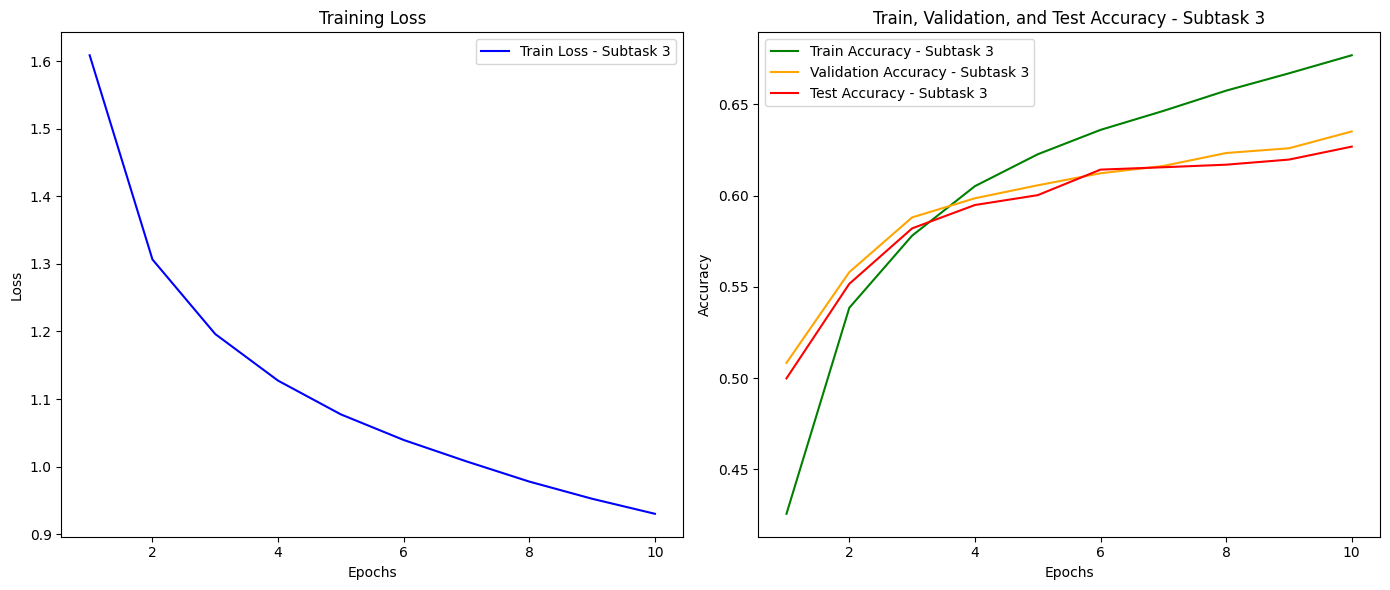

In [41]:
class SimpleCNN_subtask3(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2)  # Kernel size 5x5, stride 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)  # Kernel size 5x5, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 4 * 4, 10)  # Adjusted input size
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
# Instantiate the new model
model_subtask3 = SimpleCNN_subtask3().to(device)
# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask3.parameters(), lr=0.001)

# Train the new model and evaluate it
train_losses_subtask3, train_accuracies_subtask3, val_accuracies_subtask3, test_accuracies_subtask3 = train_and_validate(
    model_subtask3, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask3, train_accuracies_subtask3, val_accuracies_subtask3, test_accuracies_subtask3," - Subtask 3")

    Subtask 4:
    - Change Max pooling to average pooling on the best network so far and observe the changes.
    - Train and test the network and compare it with the previous best.

100%|██████████| 625/625 [00:12<00:00, 50.88it/s]


Epoch 1/10: Train Loss: 1.714, Train Acc: 0.370, Val Acc: 0.467, Test Acc: 0.469


100%|██████████| 625/625 [00:12<00:00, 48.63it/s]


Epoch 2/10: Train Loss: 1.406, Train Acc: 0.489, Val Acc: 0.523, Test Acc: 0.522


100%|██████████| 625/625 [00:12<00:00, 48.63it/s]


Epoch 3/10: Train Loss: 1.274, Train Acc: 0.546, Val Acc: 0.559, Test Acc: 0.563


100%|██████████| 625/625 [00:12<00:00, 49.34it/s]


Epoch 4/10: Train Loss: 1.165, Train Acc: 0.585, Val Acc: 0.606, Test Acc: 0.600


100%|██████████| 625/625 [00:12<00:00, 48.85it/s]


Epoch 5/10: Train Loss: 1.077, Train Acc: 0.620, Val Acc: 0.617, Test Acc: 0.617


100%|██████████| 625/625 [00:12<00:00, 49.12it/s]


Epoch 6/10: Train Loss: 1.004, Train Acc: 0.646, Val Acc: 0.637, Test Acc: 0.630


100%|██████████| 625/625 [00:12<00:00, 48.90it/s]


Epoch 7/10: Train Loss: 0.943, Train Acc: 0.667, Val Acc: 0.659, Test Acc: 0.650


100%|██████████| 625/625 [00:12<00:00, 48.72it/s]


Epoch 8/10: Train Loss: 0.893, Train Acc: 0.687, Val Acc: 0.683, Test Acc: 0.672


100%|██████████| 625/625 [00:12<00:00, 48.87it/s]


Epoch 9/10: Train Loss: 0.842, Train Acc: 0.704, Val Acc: 0.685, Test Acc: 0.683


100%|██████████| 625/625 [00:12<00:00, 48.26it/s]


Epoch 10/10: Train Loss: 0.798, Train Acc: 0.721, Val Acc: 0.693, Test Acc: 0.681


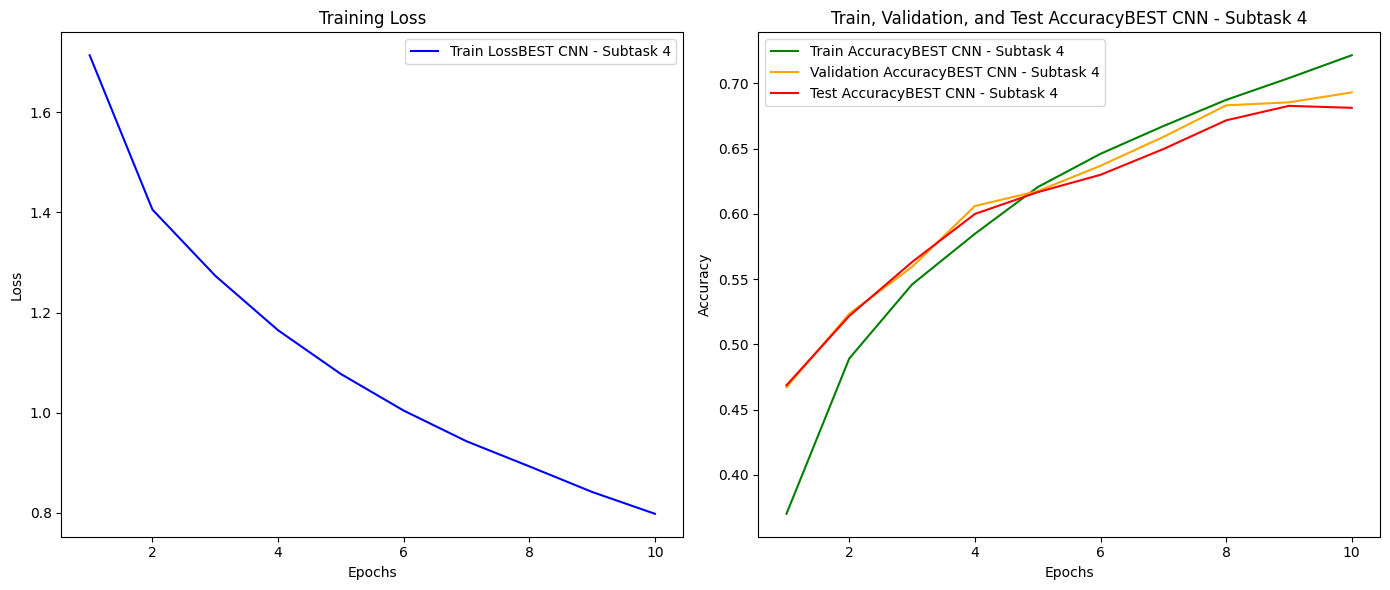

In [42]:
class SimpleCNN_subtask4(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Changed MaxPool2d to AvgPool2d
        self.fc = nn.Linear(128 * 2 * 2, 10)  # Adjusted for the deeper network from Subtask 2
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the new model
model_subtask4 = SimpleCNN_subtask4().to(device)

# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask4.parameters(), lr=0.001)

# Train the new model and evaluate it
train_losses_subtask4, train_accuracies_subtask4, val_accuracies_subtask4, test_accuracies_subtask4 = train_and_validate(
    model_subtask4, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask4, train_accuracies_subtask4, val_accuracies_subtask4, test_accuracies_subtask4,"BEST CNN - Subtask 4")


### Summary

In [61]:
# Print summary of parameters and variables
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Number of epochs: 10")
print(f"Loss function: Cross Entropy Loss")
print(f"Optimizer: Adam")
print(f"Device: {device}")

# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to print model summary
def print_model_summary(model):
    summary(model, (3, 32, 32))

# Plot comparison between subtasks
def plot_comparison(train_losses_list, train_accuracies_list, val_accuracies_list, test_accuracies_list, titles):
    epochs = range(1, len(train_losses_list[0]) + 1)

    plt.figure(figsize=(20, 10))

    # Plot training loss
    plt.subplot(2, 2, 1)
    for i, train_losses in enumerate(train_losses_list):
        plt.plot(epochs, train_losses, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for i, train_accuracies in enumerate(train_accuracies_list):
        plt.plot(epochs, train_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 3)
    for i, val_accuracies in enumerate(val_accuracies_list):
        plt.plot(epochs, val_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for i, test_accuracies in enumerate(test_accuracies_list):
        plt.plot(epochs, test_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()


Batch size: 64
Learning rate: 0.001
Number of epochs: 10
Loss function: Cross Entropy Loss
Optimizer: Adam
Device: cpu


In [62]:
print(f"Simple CNN Summary: \n")
print_model_summary(model)

Simple CNN Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 10]          40,970
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.23
Estimated Total Size (MB): 1.09
----------------------------------------------------------------


In [63]:
print(f"\nSimpleCNN_subtask_1 Summary: \n")
print_model_summary(model_subtask_1)


SimpleCNN_subtask_1 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                   [-1, 10]          20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.10
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [64]:
print(f"\nSimpleCNN_subtask_2 Summary: \n")
print_model_summary(model_subtask_2)


SimpleCNN_subtask_2 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 10]           5,130
Total p

In [65]:
print(f"\nSimpleCNN_subtask3 Summary: \n")
print_model_summary(model_subtask3)


SimpleCNN_subtask3 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]           1,216
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]          12,832
              ReLU-4             [-1, 32, 8, 8]               0
         MaxPool2d-5             [-1, 32, 4, 4]               0
            Linear-6                   [-1, 10]           5,130
Total params: 19,178
Trainable params: 19,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.07
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [66]:
print(f"\nSimpleCNN_subtask4 Summary: \n")
print_model_summary(model_subtask4)


SimpleCNN_subtask4 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         AvgPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         AvgPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         AvgPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        AvgPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 10]           5,130
Total pa

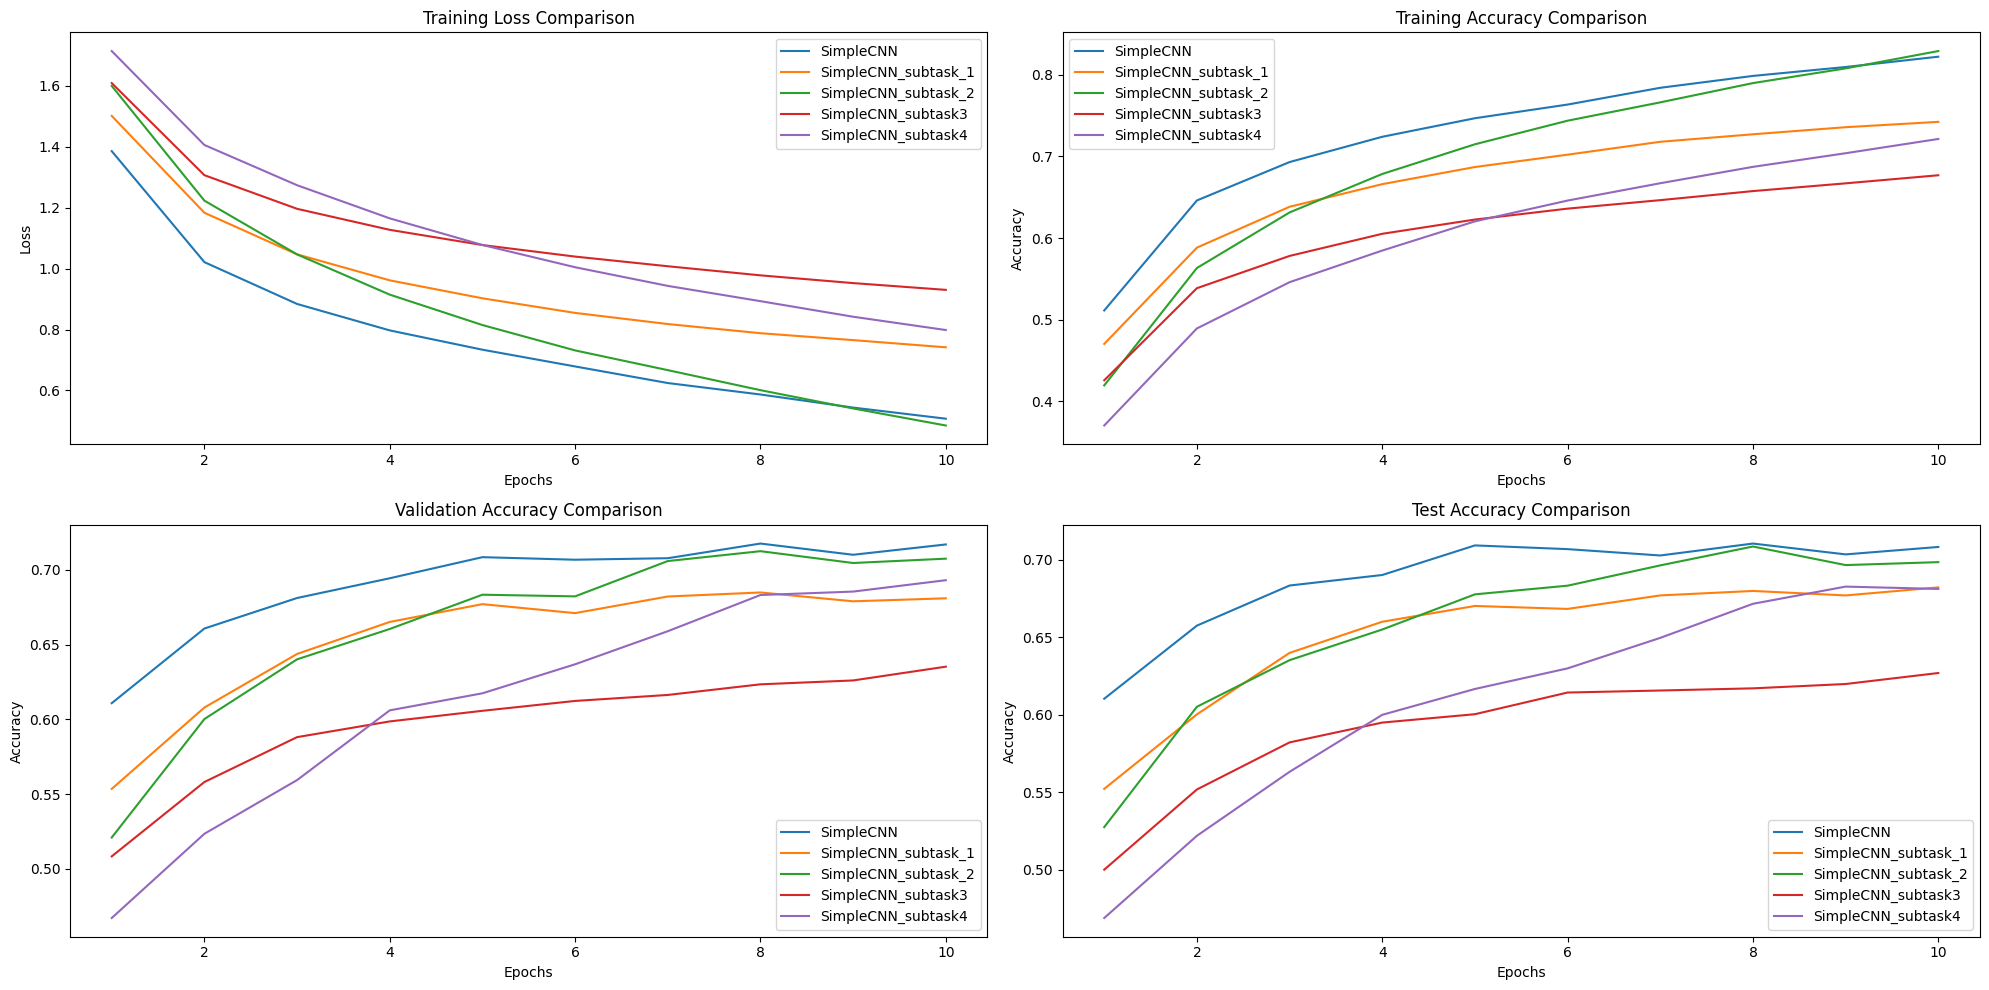

In [67]:
# Titles for the subtasks
titles = [
    "SimpleCNN",
    "SimpleCNN_subtask_1",
    "SimpleCNN_subtask_2",
    "SimpleCNN_subtask3",
    "SimpleCNN_subtask4"
]

# Plot the comparison
plot_comparison(
    [train_losses, train_losses_subtask1, train_losses_subtask2, train_losses_subtask3, train_losses_subtask4],
    [train_accuracies, train_accuracies_subtask1, train_accuracies_subtask2, train_accuracies_subtask3, train_accuracies_subtask4],
    [val_accuracies, val_accuracies_subtask1, val_accuracies_subtask2, val_accuracies_subtask3, val_accuracies_subtask4],
    [test_accuracies, test_accuracies_subtask1, test_accuracies_subtask2, test_accuracies_subtask3, test_accuracies_subtask4],
    titles
)

## Section2: Weather Classification
__Introduction:__ In this task, you’ll explore using a powerful deep learning model for classifying weather conditions based on image data. Weather classification can be valuable in various applications, such as in automated weather monitoring, agricultural planning, and disaster 
response. By leveraging a powerful model that’s known for its effectiveness in image recognition tasks, you’ll gain experience with advanced architectures that achieve high accuracy on real world images.

#### Pre-Tasks : Import Libraries

In [44]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchvision import datasets, transforms,models
from tqdm import tqdm
import sklearn

from PIL import Image
from torch.utils.data import Dataset, DataLoader,DataLoader,random_split
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix



In [ ]:
# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# Check the device
device = torch.device("cuda" if cuda_available else "cpu")
print("Device:", device)

# If CUDA is available, print additional information
if cuda_available:
    print("CUDA version:", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device capability:", torch.cuda.get_device_capability(0))

# Check if cuDNN is available
cudnn_available = torch.backends.cudnn.is_available()
print("cuDNN available:", cudnn_available)

# Check the version of cuDNN
if cudnn_available:
    print("cuDNN version:", torch.backends.cudnn.version())

# Check if MPS (Metal Performance Shaders) is available (for macOS)
mps_available = torch.backends.mps.is_available()
print("MPS available:", mps_available)

# Check if MPS is built (for macOS)
mps_built = torch.backends.mps.is_built()
print("MPS built:", mps_built)

__The dataset consists of images depicting different weather conditions, each labeled with one of 4 distinct classes: Sunrise, Shine, Cloudy, Rain. Your goal is to train a model to recognize and classify these weather conditions with high accuracy__

### Task 2.1: Download the train and test datasets from the website. The training data is given in 4 separate zip files due to space constraints in the website, download them and download the test data, preprocess it how you see fit and showcase a couple of images from each of the classes with it’s corresponding label.

In [ ]:
# Define dataset paths
data_dir = "C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data"
train_classes = ["Cloudy", "Rain", "Shine", "Sunrise"]
test_dir = "C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data/Test"

# Define class-to-index mapping manually
class_to_idx = {
    "Cloudy": 0,
    "Rain": 1,
    "Shine": 2,
    "Sunrise": 3
}

class TrainingData(Dataset):
    def __init__(self, directory_path, transform=None):
        self.directory_path = directory_path
        self.transform = transform
        self.classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_folder = os.path.join(directory_path, cls)
            for img_name in os.listdir(cls_folder):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(cls_folder, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class TestingData(Dataset):
    def __init__(self, directory_path, transform=None):
        self.directory_path = directory_path
        self.transform = transform
        self.classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for img_name in os.listdir(directory_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(directory_path, img_name))
                # Assuming the test images are named in a way that indicates their class
                for cls in self.classes:
                    if cls.lower() in img_name.lower():
                        self.labels.append(self.class_to_idx[cls])
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:

# Define the paths
data_dir = 'C:/Users/pc/Desktop/Root/University_Courses/DeepLearning/HW2/data'
train_dir = data_dir
test_dir = os.path.join(data_dir, 'Test')

# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize datasets
train_dataset = TrainingData(directory_path=train_dir, transform=transform)
test_dataset = TestingData(directory_path=test_dir, transform=transform)

# Define the dataloaders
# Split the train_dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define the dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
validation_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Print class to index mapping
print(f'Class to index mapping: {train_dataset.class_to_idx}')


# Verify if the values in both train and test loaders are legal (0 <= value <= classes number - 1)
def verify_loader(loader, num_classes):
    for images, labels in loader:
        if not all(0 <= label < num_classes for label in labels):
            return False
    return True

num_classes = len(train_classes)
train_loader_valid = verify_loader(train_loader, num_classes)
test_loader_valid = verify_loader(test_loader, num_classes)
validation_loader_valid = verify_loader(validation_loader, num_classes)

print(f'Train loader valid: {train_loader_valid}')
print(f'Test loader valid: {test_loader_valid}')
print(f'Validation loader valid: {validation_loader_valid}')


In [ ]:
# Function to visualize images with labels
def visualize_samples(data_loader, class_names):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Find one sample of each class
    samples = {}
    for img, lbl in zip(images, labels):
        if lbl.item() not in samples:
            samples[lbl.item()] = img
        if len(samples) == len(class_names):
            break

    # Denormalize images
    for lbl in samples:
        samples[lbl] = samples[lbl] * 0.5 + 0.5

    plt.figure(figsize=(12, 6))
    for i, lbl in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(np.transpose(samples[lbl].numpy(), (1, 2, 0)))
        plt.title(class_names[lbl])
        plt.axis("off")
    plt.show()

# Visualize some training images
visualize_samples(train_loader, train_classes)

### Task 2.2: Use any one of the model architectures we talked about in class, load a pre trained version from pytorch and adapt it to classify the 4 weather classes. Fine-tune the model to maximize its performance on the dataset.

We used the ResNet-18 model from torchvision.models because it is a well-known, pre-trained convolutional neural network that performs well on image classification tasks. Here are the key points:

Pre-trained Model: ResNet-18 is pre-trained on a large dataset (ImageNet), which helps in transferring learned features to your specific task, improving performance and reducing training time.
1. Adaptation: You modified the final fully connected layer (model.fc) to output predictions for 4 weather classes instead of the original 1000 classes.
2. Dropout Layer: Added a dropout layer to prevent overfitting.
3. Device Transfer: Moved the model to the appropriate device (CPU or GPU) for efficient computation.
4. Model Summary: Used torchsummary to print a summary of the model architecture, ensuring it is correctly set up for input images of size 128x128 with 3 color channels.

This approach leverages transfer learning to adapt a powerful model to your specific classification task.

In [45]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
# change the output layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, num_classes)
)
model = model.to(device)


__Task 2.3: Loss Function__
In class, we showcased different types of loss function, create a 
custom class called:
```py
Class MyLossFunction(*arguments*):
 *write your code here
 ```

Write your custom loss function mathematically using Latex in a text cell above the code cell in the notebook and implement your own custom loss function, you may not use a pre-built loss function from pytorch, even if it’s a regular CE/MSE function.

In [ ]:
class MyLossFunction(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=4):
        super(MyLossFunction, self).__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes

    # forward pass of the loss function
    def forward(self, predictions, targets):
        assert targets.min() >= 0 and targets.max() < self.num_classes, \
            f"Targets values should be in the range [0, {self.num_classes - 1}]!"
        
        # convert targets to one-hot encoding 
        targets_one_hot = torch.zeros_like(predictions).scatter_(1, targets.unsqueeze(1), 1)
        # smooth the one-hot encoding
        smooth_targets = (1 - self.smoothing) * targets_one_hot + self.smoothing / self.num_classes
        # calculate the loss
        loss = -smooth_targets * torch.log_softmax(predictions, dim=1)
        return loss.sum(dim=1).mean()

criterion = MyLossFunction(smoothing=0.1, num_classes=len(train_classes))

### Task 2.4: After training the model, evaluate it on the test set. After training the model, evaluate it on the test set.

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_losses = []
    val_losses = []
    test_accuracies = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        # Evaluate on the test set
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, '
              f'Test Acc: {test_accuracies[-1]:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies


### Task 2.5: When evaluating on the test set, show a handful of images with their original label and the predicted label.

In [ ]:
criterion = MyLossFunction()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train and validate the model
num_epochs = 20
train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies = train_and_validate(
    model, train_loader, validation_loader, criterion, optimizer, num_epochs
)

Epoch 1/20, Train Loss: 0.7680, Train Acc: 0.8427, Val Loss: 2.0754, Val Acc: 0.7277, Test Acc: 0.7833
Epoch 2/20, Train Loss: 0.5347, Train Acc: 0.9378, Val Loss: 0.4536, Val Acc: 0.9718, Test Acc: 0.9500
Epoch 3/20, Train Loss: 0.4857, Train Acc: 0.9495, Val Loss: 0.4942, Val Acc: 0.9343, Test Acc: 0.9667
Epoch 4/20, Train Loss: 0.4559, Train Acc: 0.9777, Val Loss: 0.4602, Val Acc: 0.9577, Test Acc: 0.9667
Epoch 5/20, Train Loss: 0.4296, Train Acc: 0.9765, Val Loss: 0.4011, Val Acc: 0.9718, Test Acc: 0.9833
Epoch 6/20, Train Loss: 0.4043, Train Acc: 0.9906, Val Loss: 0.5701, Val Acc: 0.9296, Test Acc: 0.9167
Epoch 7/20, Train Loss: 0.4092, Train Acc: 0.9883, Val Loss: 0.4267, Val Acc: 0.9718, Test Acc: 0.9333
Epoch 8/20, Train Loss: 0.3905, Train Acc: 0.9953, Val Loss: 0.4238, Val Acc: 0.9671, Test Acc: 0.9667
Epoch 9/20, Train Loss: 0.4030, Train Acc: 0.9847, Val Loss: 0.3830, Val Acc: 0.9906, Test Acc: 0.9833
Epoch 10/20, Train Loss: 0.4126, Train Acc: 0.9894, Val Loss: 0.4353, Val

### Task 2.6: Also, show the results of the network on the test set using:
 1) test set accuracy percentage (like we always do)
 2) Confusion matrix

 You may use any regularization techniques that you want, the goal is to achieve the highest accuracy that you can.

In [ ]:
# Function to plot the metrics
def plot_metrics(train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies, title=''):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss' + title, color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss' + title, color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy' + title, color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy'+ title, color='orange')
    plt.plot(epochs, test_accuracies, label='Test Accuracy' + title, color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train, Validation, and Test Accuracy' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to visualize correct and incorrect predictions
def visualize_predictions(model, data_loader, class_names, num_samples=5):
        model.eval()
        correct_samples = []
        incorrect_samples = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for i in range(len(labels)):
                    if preds[i] == labels[i]:
                        correct_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    else:
                        incorrect_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))

                    if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                        break
                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    break

        # Plot correct predictions
        plt.figure(figsize=(9, 3))
        # Plot incorrect predictions
        for i, (img, true_label, pred_label) in enumerate(incorrect_samples[:num_samples]):
            img = img * 0.5 + 0.5  # Denormalize
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
            plt.axis('off')

        for i, (img, true_label, pred_label) in enumerate(correct_samples[:num_samples]):
            img = img * 0.5 + 0.5  # Denormalize
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
            plt.axis('off')
        

        plt.tight_layout()
        plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

Test Set Accuracy: 95.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42195398..1.5987669].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02328968..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7055321].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31064308..1.7415688].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5541571..1.82].
Clipp

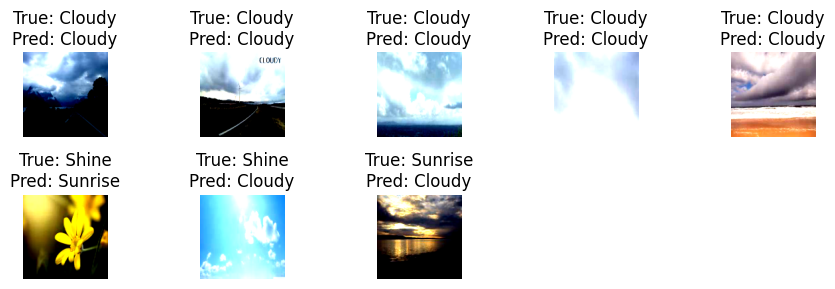

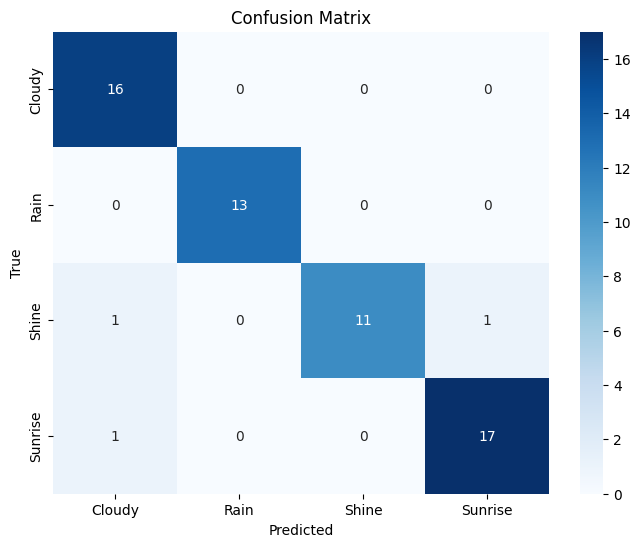

In [ ]:
# Calculate test set accuracy percentage
test_accuracy = test_accuracies[-1] * 100
print(f'Test Set Accuracy: {test_accuracy:.2f}%')

# Visualize correct and incorrect predictions
visualize_predictions(model, test_loader, train_classes)

# Plot the confusion matrix for the test set
plot_confusion_matrix(model, test_loader, train_classes)

__Task 2.7:__ Plot the training, validation and testing accuracy as well as the loss function values as a function to the number of epochs.
 The training and validation plots should be showcased in one plot together.

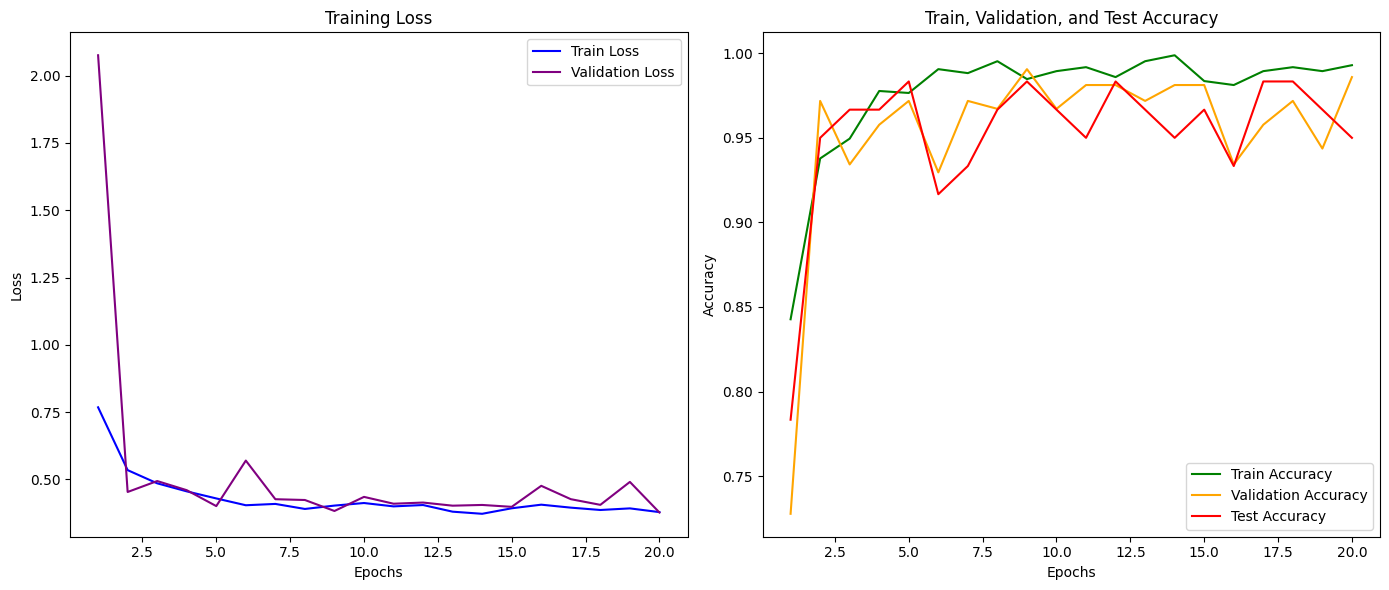

In [ ]:
# Plot the metrics
plot_metrics(train_losses,val_losses, train_accuracies, val_accuracies, test_accuracies, '')

### Task 2.8: For the final step, use any projection algorithm we talked about in the class to showcase (visualize) how the model classified the data on a 2D plane.

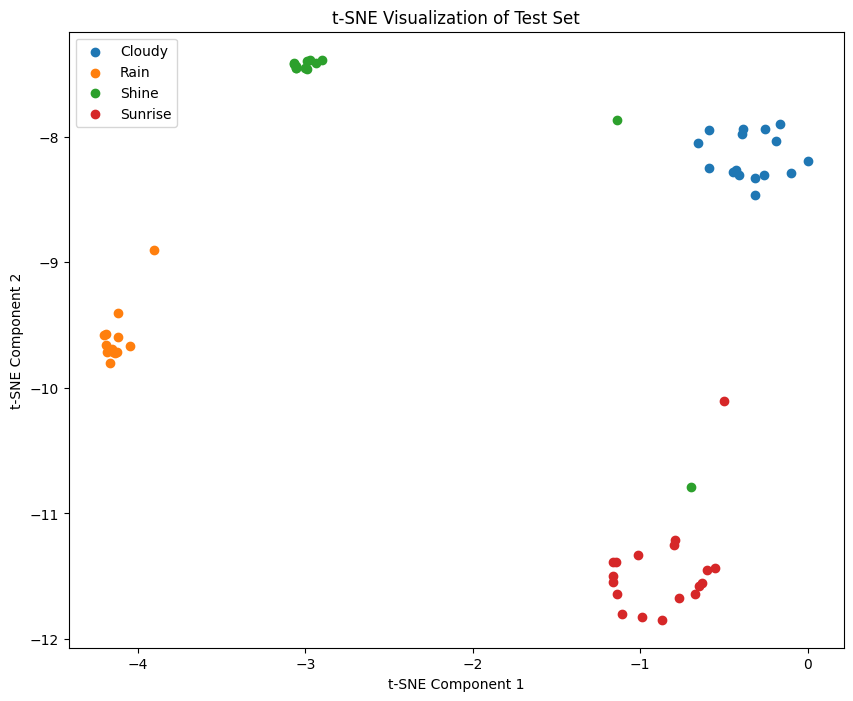

In [ ]:
# Function to extract features from the model
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features from the test set
test_features, test_labels = extract_features(model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(train_classes):
    indices = test_labels == i
    plt.scatter(test_features_2d[indices, 0], test_features_2d[indices, 1], label=class_name)

plt.legend()
plt.title('t-SNE Visualization of Test Set')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Summary

In [ ]:
# Print summary of parameters and variables
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Number of epochs: 20")
print(f"Loss function: Smoothed Cross Entropy Loss")
print(f"Optimizer: Adam")
print(f"Device: {device}")
print(f"Model architecture: ResNet-18")
print(f"Number of classes: {num_classes}")
print(f"number of all model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
# Print the model summary
summary(model, (3, 32, 32))

Batch size: 32
Learning rate: 0.001
Number of epochs: 20
Loss function: Smoothed Cross Entropy Loss
Optimizer: Adam
Device: cpu
Model architecture: ResNet-18
Number of classes: 4
number of all model parameters: 11178564
number of trainable parameters: 11178564
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [

## Submission:
For this assignment, make sure your submission is clear and well organized. You should include a notebook for each part of the assignment with all code cells run and explained.  There’s no need to put the files in a zip file, just submit your 2 `ipynb` files with their names being `HW1_ID1_ID2.ipynb` OR `HW1_ID2_ID1.ipynb`.

- Add text cells to introduce each section, explaining what you did and why. Keep your notebooks tidy and easy to follow, with the names of all group members at the top.

- In each notebook, include comments in your code and use text to describe what you’re doing in each section. Visualize your results with plots that help explain the data and model performance.

- Finally, print each model you use, showing the layer details and the total number of parameters.

- Only the pytorch library can be used as a deep learning tool to work with the models, you can’t use keras or tensorflow under any 
circumstances, you may use other libraries for manipulating the dataset and preprocessing as long as it doesn’t affect the model definition within pytorch.